In [2]:
!pip install torch


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!python -m pip install --upgrade pip

   ---------------------------------------- 0.0/1.8 MB ? eta -:--:--
   ----- ---------------------------------- 0.3/1.8 MB ? eta -:--:--
   ---------------------------- ----------- 1.3/1.8 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 1.8/1.8 MB 4.6 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 25.0.1
    Uninstalling pip-25.0.1:
      Successfully uninstalled pip-25.0.1


In [1]:
# ✅ GCN Model to Predict AADT using Road Segment Data (PyTorch Geometric)

# 📦 Step 1: Install dependencies
!pip install torch torch_geometric scikit-learn shapely geopandas openpyxl

# 📂 Step 2: Load and preprocess your data
import pandas as pd
import shapely.wkt
from sklearn.neighbors import NearestNeighbors
import torch
from torch_geometric.data import Data
import numpy as np

In [67]:
# Load Excel file
df = pd.read_excel("AADT_with_snow.xlsx")

# Drop rows with missing key fields and filter invalid values
df = df.dropna(subset=["AADT", "snow_depth", "wkt_geom", "SHAPE_Leng", "Speed"])

In [69]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors
import shapely.wkt
import numpy as np

# Extract coordinates
df["geometry"] = df["wkt_geom"].apply(shapely.wkt.loads)

In [81]:
# Nearest neighbors for edges
coords = df["wkt_geom"].apply(shapely.wkt.loads).apply(lambda p: (p.x, p.y)).tolist()

k = 3
nn = NearestNeighbors(n_neighbors=k + 1).fit(coords)
distances, indices = nn.kneighbors(coords)

G = nx.Graph()
for i, coord in enumerate(coords):
    G.add_node(i, pos=coord, snow=df.iloc[i]["snow_depth"])
    for j in indices[i][1:]:
        G.add_edge(i, j, aadt=df.iloc[i]["AADT"])

pos = nx.get_node_attributes(G, "pos")
snow_depth = np.array([G.nodes[n]["snow"] for n in G.nodes], dtype=float)
# Ensure values are within 0–35 inch range
snow_depth = np.clip(snow_depth, 0, 35)
aadt_values = np.array([G.edges[e]["aadt"] for e in G.edges])

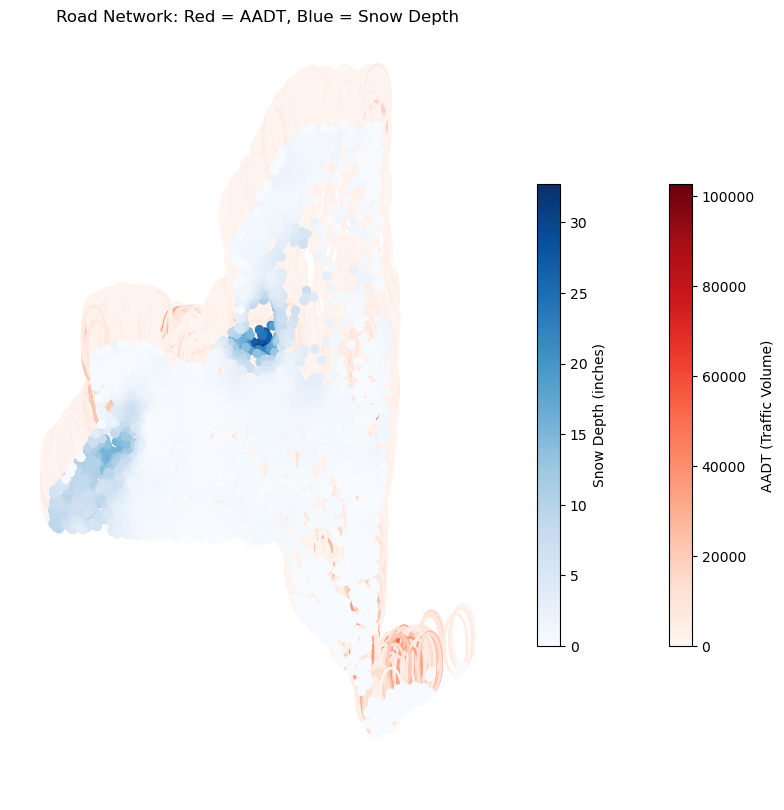

In [83]:
plt.figure(figsize=(10, 10))
edges = nx.draw_networkx_edges(
    G, pos, edge_color=aadt_values, edge_cmap=plt.cm.Reds,
    edge_vmin=aadt_values.min(), edge_vmax=aadt_values.max(), width=2
)
nodes = nx.draw_networkx_nodes(
    G, pos, node_size=30, node_color=snow_depth, cmap=plt.cm.Blues,
    vmin=snow_depth.min(), vmax=snow_depth.max()
)

plt.title("Road Network: Red = AADT, Blue = Snow Depth")
plt.axis("off")
cb1 = plt.colorbar(edges, shrink=0.6)
cb1.set_label("AADT (Traffic Volume)", fontsize=10)
cb2 = plt.colorbar(nodes, shrink=0.6)
cb2.set_label("Snow Depth (inches)", fontsize=10)
plt.show()

In [25]:
# Filter out invalid values
# Keep Speed_Limit between 50 and 65 mph, SHAPE_Leng > 0
# Optionally clip extreme lengths to 99th percentile
length_clip = df["SHAPE_Leng"].quantile(0.99)
df = df[(df["SHAPE_Leng"] > 0) & (df["Speed"] >= 50) & (df["Speed"] <= 65)]
df.loc[df["SHAPE_Leng"] > length_clip, "SHAPE_Leng"] = length_clip

In [27]:
# Extract coordinates from WKT
coords = df["wkt_geom"].apply(shapely.wkt.loads).apply(lambda p: (p.x, p.y))
coord_array = np.array(coords.tolist())

In [29]:
# Step 3: Construct edge_index based on nearest neighbors
nn = NearestNeighbors(n_neighbors=4, algorithm="ball_tree").fit(coord_array)
distances, indices = nn.kneighbors(coord_array)

edges = []
for i, nbrs in enumerate(indices):
    for j in nbrs[1:]:  # skip self
        edges.append((i, j))

edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

# 📊 Step 4: Normalize features and label to stabilize training
from sklearn.preprocessing import StandardScaler

# Standardize input features
scaler_x = StandardScaler()
features_scaled = scaler_x.fit_transform(df[["snow_depth", "SHAPE_Leng", "Speed"]])

# Standardize target (AADT)
scaler_y = StandardScaler()
target_scaled = scaler_y.fit_transform(df[["AADT"]])

x = torch.tensor(features_scaled, dtype=torch.float)
y = torch.tensor(target_scaled.squeeze(), dtype=torch.float)

# Validate input
print("Any NaN in x?", torch.isnan(x).any().item())
print("Any NaN in y?", torch.isnan(y).any().item())
print("Any Inf in x?", torch.isinf(x).any().item())
print("x mean/std:", x.mean().item(), x.std().item())

Any NaN in x? False
Any NaN in y? False
Any Inf in x? False
x mean/std: 3.250239188901105e-09 1.0000118017196655


In [35]:
#  Step 5: Create GCN-ready data object
data = Data(x=x, edge_index=edge_index, y=y)
print(data)

Data(x=[14084, 3], edge_index=[2, 42252], y=[14084])


In [37]:
# Step 6: Define GCN model (regression)
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch.nn import Linear

class GCNRegression(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.lin(x)
        return x.squeeze()  # regression

In [39]:
# Step 7: Train the model
from torch_geometric.data import DataLoader

model = GCNRegression(in_channels=x.shape[1], hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()

model.train()
for epoch in range(100):
    optimizer.zero_grad()
    out = model(data)
    if torch.isnan(out).any():
        print("❌ Model output contains NaN. Check input features or model weights.")
    loss = criterion(out, data.y)
    loss.backward()
    optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1:03d}, Loss: {loss.item():.4f}")

Epoch 010, Loss: 0.9061
Epoch 020, Loss: 0.8914
Epoch 030, Loss: 0.8839
Epoch 040, Loss: 0.8796
Epoch 050, Loss: 0.8781
Epoch 060, Loss: 0.8771
Epoch 070, Loss: 0.8761
Epoch 080, Loss: 0.8751
Epoch 090, Loss: 0.8740
Epoch 100, Loss: 0.8730


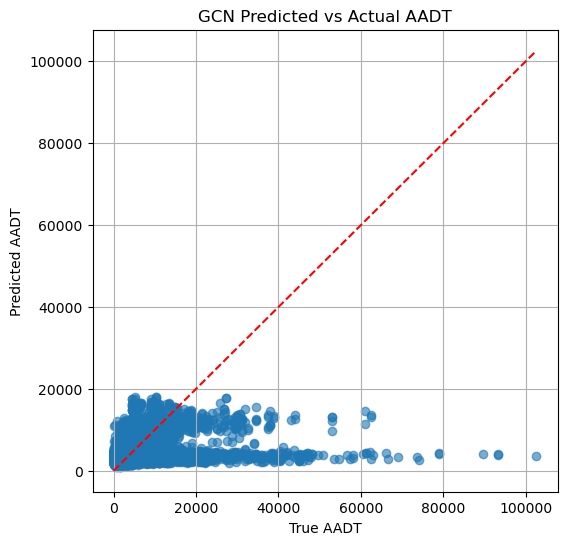

In [41]:
# Step 8: Visualize prediction vs actual
import matplotlib.pyplot as plt

model.eval()
pred_scaled = model(data).detach().numpy().reshape(-1, 1)
pred = scaler_y.inverse_transform(pred_scaled)
true = df["AADT"].values

plt.figure(figsize=(6,6))
plt.scatter(true, pred, alpha=0.6)
plt.xlabel("True AADT")
plt.ylabel("Predicted AADT")
plt.title("GCN Predicted vs Actual AADT")
plt.grid(True)
plt.plot([true.min(), true.max()], [true.min(), true.max()], 'r--')
plt.show()